<a href="https://colab.research.google.com/github/seunghokimS/DACON-Temperature-prediction-/blob/main/%EA%B8%B0%EC%98%A8%EC%98%88%EC%B8%A1_Modeling(Prophet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import matplotlib.dates as mdates
from matplotlib import container
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV
# from pmdarima import auto_arima

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from hyperopt import hp, fmin, tpe, STATUS_OK

import torch
import torch.nn as nn

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/공모전(Dacon)/기온예측/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/공모전(Dacon)/기온예측/sample_submission.csv')

In [ ]:
# def preprocessing(df):
#     df = df.copy()
#     df['일시'] = pd.to_datetime(df['일시'])
#     df['연'] = df['일시'].dt.year
#     df['월'] = df['일시'].dt.month
#     df['월_cos'] = np.cos(2 * np.pi * df['월'] / 12)
#     df['월_sin'] = np.sin(2 * np.pi * df['월'] / 12)
#     df.drop(columns=['월'], inplace=True)
#     df.set_index('일시', inplace=True)
#     df = df[['평균기온','연','월_cos', '월_sin']]
#     return df

In [ ]:
def preprocessing(df):
    df = df.copy()
    df['일시'] = pd.to_datetime(df['일시'])
    df = df.rename(columns={'일시':'ds','평균기온':'y'})
    df = df[['ds','y']]
    return df


In [ ]:
df = preprocessing(train)

In [ ]:
df

,ds,y
0,1960-01-01,-1.6
1,1960-01-02,-1.9
2,1960-01-03,4.0
3,1960-01-04,7.5
4,1960-01-05,-4.6
...,...,...
23006,2022-12-27,-2.6
23007,2022-12-28,-3.3
23008,2022-12-29,-2.9
23009,2022-12-30,-1.8


In [ ]:
df = preprocessing(train)
sub = preprocessing(submission)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/r4mgbo98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/j0_c1mv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44544', 'data', 'file=/tmp/tmpzumb7ln2/r4mgbo98.json', 'init=/tmp/tmpzumb7ln2/j0_c1mv8.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelic8y2933/prophet_model-20231231124310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


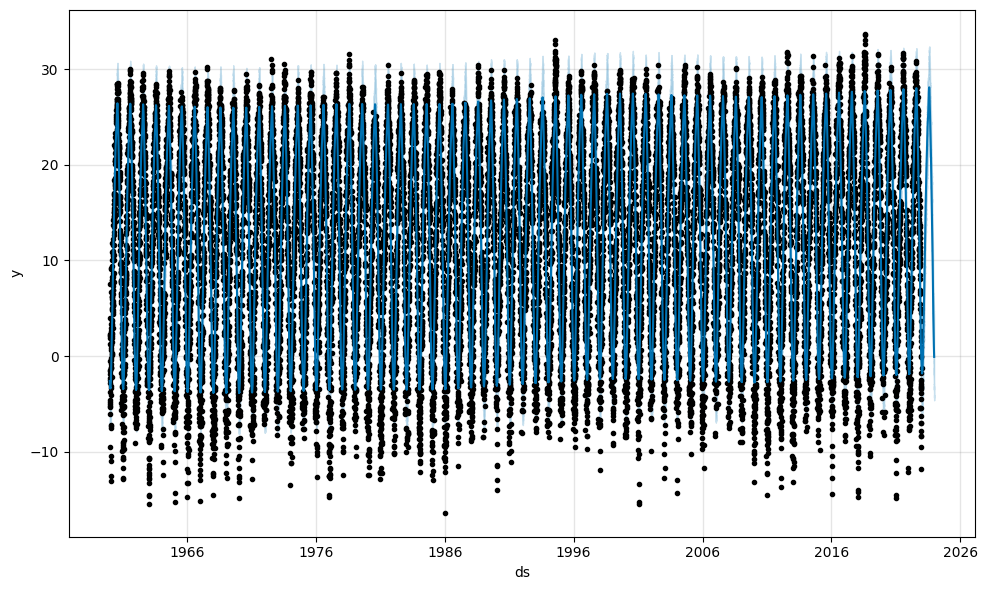

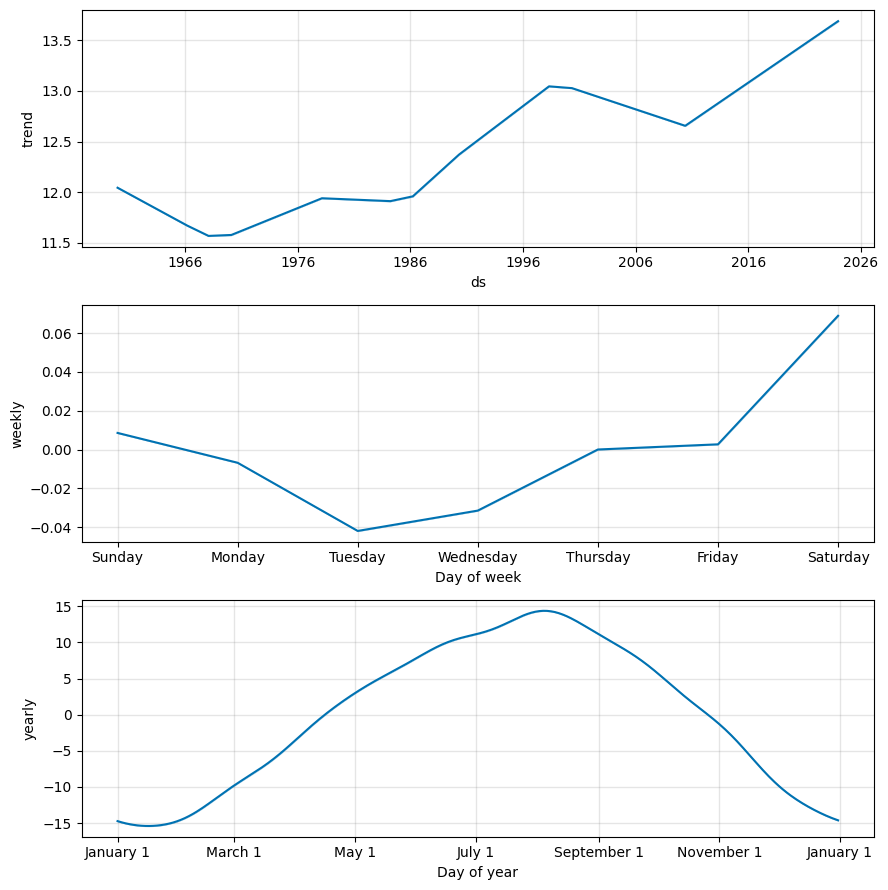

In [ ]:

m = Prophet(yearly_seasonality=True)
m.fit(df)

# 검증 데이터에 대한 예측 수행
future = m.make_future_dataframe(periods=358)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,12.043066,-6.442746,1.513991,12.043066,12.043066,-14.660640,-14.660640,-14.660640,0.002687,0.002687,0.002687,-14.663327,-14.663327,-14.663327,0.0,0.0,0.0,-2.617574
1,1960-01-02,12.042899,-6.652318,1.397556,12.042899,12.042899,-14.682180,-14.682180,-14.682180,0.068912,0.068912,0.068912,-14.751092,-14.751092,-14.751092,0.0,0.0,0.0,-2.639281
2,1960-01-03,12.042733,-7.080773,1.554673,12.042733,12.042733,-14.825004,-14.825004,-14.825004,0.008567,0.008567,0.008567,-14.833571,-14.833571,-14.833571,0.0,0.0,0.0,-2.782271
3,1960-01-04,12.042567,-7.143611,1.177622,12.042567,12.042567,-14.917454,-14.917454,-14.917454,-0.006810,-0.006810,-0.006810,-14.910644,-14.910644,-14.910644,0.0,0.0,0.0,-2.874887
4,1960-01-05,12.042401,-7.023317,1.059277,12.042401,12.042401,-15.024141,-15.024141,-15.024141,-0.041932,-0.041932,-0.041932,-14.982209,-14.982209,-14.982209,0.0,0.0,0.0,-2.981740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23364,2023-12-20,13.689237,-3.659936,4.460477,13.685137,13.693264,-13.288650,-13.288650,-13.288650,-0.031449,-0.031449,-0.031449,-13.257201,-13.257201,-13.257201,0.0,0.0,0.0,0.400586
23365,2023-12-21,13.689445,-3.749299,4.443391,13.685309,13.693522,-13.395909,-13.395909,-13.395909,0.000025,0.000025,0.000025,-13.395934,-13.395934,-13.395934,0.0,0.0,0.0,0.293537
23366,2023-12-22,13.689654,-4.351371,4.276858,13.685480,13.693779,-13.528405,-13.528405,-13.528405,0.002687,0.002687,0.002687,-13.531092,-13.531092,-13.531092,0.0,0.0,0.0,0.161249
23367,2023-12-23,13.689863,-4.061051,4.144808,13.685652,13.694036,-13.593727,-13.593727,-13.593727,0.068912,0.068912,0.068912,-13.662638,-13.662638,-13.662638,0.0,0.0,0.0,0.096136


In [ ]:
predict = list(forecast[forecast['ds'].apply(lambda x:x.year)==2023]['yhat'])

In [ ]:
submission['평균기온'] = np.round(predict,1)

In [ ]:
# from google.colab import files
# submission.to_csv('(12.30)prophet_basic.csv', index = False)
# files.download('(12.30)prophet_basic.csv')

  0%|          | 0/35 [00:00<?, ?trial/s, best loss=?]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/0ogn3kp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/226w1ido.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45527', 'data', 'file=/tmp/tmpzumb7ln2/0ogn3kp7.json', 'init=/tmp/tmpzumb7ln2/226w1ido.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelebvm4jun/prophet_model-20231231124327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  3%|▎         | 1/35 [00:13<07:38, 13.47s/trial, best loss: 2.9197046599020235]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/lqrcfd27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/5uh6lpn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96887', 'data', 'file=/tmp/tmpzumb7ln2/lqrcfd27.json', 'init=/tmp/tmpzumb7ln2/5uh6lpn6.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modeloplli_yh/prophet_model-20231231124341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  6%|▌         | 2/35 [00:27<07:33, 13.75s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/ti0hr8up.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/0hjr3qe9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22541', 'data', 'file=/tmp/tmpzumb7ln2/ti0hr8up.json', 'init=/tmp/tmpzumb7ln2/0hjr3qe9.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model_jw681ls/prophet_model-20231231124356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  9%|▊         | 3/35 [00:40<07:12, 13.52s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/p9d_03rl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/e1zqoavw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3093', 'data', 'file=/tmp/tmpzumb7ln2/p9d_03rl.json', 'init=/tmp/tmpzumb7ln2/e1zqoavw.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelx9z0vg6j/prophet_model-20231231124408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 11%|█▏        | 4/35 [00:52<06:39, 12.89s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/zdzrfsyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/jfdpe3kt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96290', 'data', 'file=/tmp/tmpzumb7ln2/zdzrfsyl.json', 'init=/tmp/tmpzumb7ln2/jfdpe3kt.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelcrt2js1w/prophet_model-20231231124421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 14%|█▍        | 5/35 [01:04<06:13, 12.45s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/sxg4fx5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/yidkcs05.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29430', 'data', 'file=/tmp/tmpzumb7ln2/sxg4fx5e.json', 'init=/tmp/tmpzumb7ln2/yidkcs05.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model4zb5e26v/prophet_model-20231231124432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 17%|█▋        | 6/35 [01:16<06:00, 12.45s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/8oilzbqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/fq90idi1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82756', 'data', 'file=/tmp/tmpzumb7ln2/8oilzbqk.json', 'init=/tmp/tmpzumb7ln2/fq90idi1.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelqgfvp546/prophet_model-20231231124444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 20%|██        | 7/35 [01:27<05:29, 11.77s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/nhei8dv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/2f8qwyur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=313', 'data', 'file=/tmp/tmpzumb7ln2/nhei8dv4.json', 'init=/tmp/tmpzumb7ln2/2f8qwyur.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model8s91kwp2/prophet_model-20231231124454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 23%|██▎       | 8/35 [01:43<06:01, 13.40s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/6zbup24y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/lcyrytj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28595', 'data', 'file=/tmp/tmpzumb7ln2/6zbup24y.json', 'init=/tmp/tmpzumb7ln2/lcyrytj3.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelxuyo8rt3/prophet_model-20231231124511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 26%|██▌       | 9/35 [01:53<05:15, 12.14s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/lrdveu6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/465r9rin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85402', 'data', 'file=/tmp/tmpzumb7ln2/lrdveu6l.json', 'init=/tmp/tmpzumb7ln2/465r9rin.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelgmbibbzz/prophet_model-20231231124522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 29%|██▊       | 10/35 [02:10<05:40, 13.60s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/bdtv85os.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/jmyncz39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11591', 'data', 'file=/tmp/tmpzumb7ln2/bdtv85os.json', 'init=/tmp/tmpzumb7ln2/jmyncz39.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modeltjpy1nr9/prophet_model-20231231124539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 31%|███▏      | 11/35 [02:21<05:09, 12.91s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/9d31qdo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/x2benej_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65353', 'data', 'file=/tmp/tmpzumb7ln2/9d31qdo1.json', 'init=/tmp/tmpzumb7ln2/x2benej_.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelokbp7qb7/prophet_model-20231231124548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 34%|███▍      | 12/35 [02:38<05:27, 14.26s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/ro7tlsi9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/73sg2qhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13763', 'data', 'file=/tmp/tmpzumb7ln2/ro7tlsi9.json', 'init=/tmp/tmpzumb7ln2/73sg2qhe.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model98w95ctm/prophet_model-20231231124607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 37%|███▋      | 13/35 [02:51<05:05, 13.90s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/eeoqo16u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/eepkjky4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99108', 'data', 'file=/tmp/tmpzumb7ln2/eeoqo16u.json', 'init=/tmp/tmpzumb7ln2/eepkjky4.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_models6gj5izq/prophet_model-20231231124620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 40%|████      | 14/35 [03:09<05:15, 15.02s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/3da5gqw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/wj78f_75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66302', 'data', 'file=/tmp/tmpzumb7ln2/3da5gqw1.json', 'init=/tmp/tmpzumb7ln2/wj78f_75.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelzff90ewe/prophet_model-20231231124636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 43%|████▎     | 15/35 [03:25<05:03, 15.15s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/8qbaj4_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/5wpqvvr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25838', 'data', 'file=/tmp/tmpzumb7ln2/8qbaj4_6.json', 'init=/tmp/tmpzumb7ln2/5wpqvvr2.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelh2a46rwd/prophet_model-20231231124652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 46%|████▌     | 16/35 [03:37<04:32, 14.37s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/jzh82zjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/ex60f3v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15658', 'data', 'file=/tmp/tmpzumb7ln2/jzh82zjq.json', 'init=/tmp/tmpzumb7ln2/ex60f3v8.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model0oh1pba2/prophet_model-20231231124705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 49%|████▊     | 17/35 [03:50<04:09, 13.86s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/573y080b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/suu1x_48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87384', 'data', 'file=/tmp/tmpzumb7ln2/573y080b.json', 'init=/tmp/tmpzumb7ln2/suu1x_48.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model5_zenjmw/prophet_model-20231231124717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 51%|█████▏    | 18/35 [04:03<03:54, 13.77s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/n70y4501.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/67_uakxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41303', 'data', 'file=/tmp/tmpzumb7ln2/n70y4501.json', 'init=/tmp/tmpzumb7ln2/67_uakxm.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model8kk0gnwp/prophet_model-20231231124732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 54%|█████▍    | 19/35 [04:22<04:03, 15.23s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/dknpfdpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/7ujjt318.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16942', 'data', 'file=/tmp/tmpzumb7ln2/dknpfdpf.json', 'init=/tmp/tmpzumb7ln2/7ujjt318.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelhiu8ibdw/prophet_model-20231231124750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 57%|█████▋    | 20/35 [04:38<03:54, 15.62s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/lv2gs3iz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/c3l_2xgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70626', 'data', 'file=/tmp/tmpzumb7ln2/lv2gs3iz.json', 'init=/tmp/tmpzumb7ln2/c3l_2xgc.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelvqnkvsr8/prophet_model-20231231124806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 60%|██████    | 21/35 [05:02<04:13, 18.12s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/dcyw62dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/re6ot0mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13507', 'data', 'file=/tmp/tmpzumb7ln2/dcyw62dv.json', 'init=/tmp/tmpzumb7ln2/re6ot0mh.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model1f8zfo6p/prophet_model-20231231124831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 63%|██████▎   | 22/35 [05:26<04:15, 19.66s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/pkt16lzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/3bschcew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48', 'data', 'file=/tmp/tmpzumb7ln2/pkt16lzx.json', 'init=/tmp/tmpzumb7ln2/3bschcew.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model10fd0_3h/prophet_model-20231231124853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 66%|██████▌   | 23/35 [05:45<03:55, 19.63s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/ihbi03__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/431djce3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91558', 'data', 'file=/tmp/tmpzumb7ln2/ihbi03__.json', 'init=/tmp/tmpzumb7ln2/431djce3.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model3wb7v089/prophet_model-20231231124913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 69%|██████▊   | 24/35 [06:00<03:19, 18.17s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/2gatcy_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/1kbo7dtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61023', 'data', 'file=/tmp/tmpzumb7ln2/2gatcy_x.json', 'init=/tmp/tmpzumb7ln2/1kbo7dtg.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelatk1rv37/prophet_model-20231231124928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 71%|███████▏  | 25/35 [06:21<03:10, 19.05s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/w6gnswxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/40198rzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79231', 'data', 'file=/tmp/tmpzumb7ln2/w6gnswxd.json', 'init=/tmp/tmpzumb7ln2/40198rzi.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelsjzt8cmn/prophet_model-20231231124950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 74%|███████▍  | 26/35 [06:44<03:01, 20.17s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/2vl5hq19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/0gt1ylle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12497', 'data', 'file=/tmp/tmpzumb7ln2/2vl5hq19.json', 'init=/tmp/tmpzumb7ln2/0gt1ylle.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelkot2xa25/prophet_model-20231231125011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 77%|███████▋  | 27/35 [07:01<02:34, 19.30s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/__gbpcac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/gdsdat1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76100', 'data', 'file=/tmp/tmpzumb7ln2/__gbpcac.json', 'init=/tmp/tmpzumb7ln2/gdsdat1e.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model_qhjzgnj/prophet_model-20231231125029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 80%|████████  | 28/35 [07:16<02:06, 18.04s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/scanfybn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/vs9r6z6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98773', 'data', 'file=/tmp/tmpzumb7ln2/scanfybn.json', 'init=/tmp/tmpzumb7ln2/vs9r6z6h.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model6vfv996k/prophet_model-20231231125044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 83%|████████▎ | 29/35 [07:36<01:50, 18.40s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/_mp8d20u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/kvqglef6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35457', 'data', 'file=/tmp/tmpzumb7ln2/_mp8d20u.json', 'init=/tmp/tmpzumb7ln2/kvqglef6.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model94mhby38/prophet_model-20231231125104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:51:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:51:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 86%|████████▌ | 30/35 [07:52<01:29, 17.85s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/yr9by46n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/sfzdf4qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8839', 'data', 'file=/tmp/tmpzumb7ln2/yr9by46n.json', 'init=/tmp/tmpzumb7ln2/sfzdf4qg.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelf76pdzoy/prophet_model-20231231125121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 89%|████████▊ | 31/35 [08:08<01:08, 17.24s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/qvot0v1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/gkre9x5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41706', 'data', 'file=/tmp/tmpzumb7ln2/qvot0v1u.json', 'init=/tmp/tmpzumb7ln2/gkre9x5r.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelrirkn3tm/prophet_model-20231231125137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 91%|█████████▏| 32/35 [08:31<00:56, 18.95s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/4syf2e51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/humtt3vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5715', 'data', 'file=/tmp/tmpzumb7ln2/4syf2e51.json', 'init=/tmp/tmpzumb7ln2/humtt3vb.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model8ozm7flz/prophet_model-20231231125158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 94%|█████████▍| 33/35 [08:46<00:35, 17.87s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/oom66ph0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/ib2j_wey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88589', 'data', 'file=/tmp/tmpzumb7ln2/oom66ph0.json', 'init=/tmp/tmpzumb7ln2/ib2j_wey.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelboijclzh/prophet_model-20231231125214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:52:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:52:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 97%|█████████▋| 34/35 [09:03<00:17, 17.65s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/j2_7xg7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/_wj7z18q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55524', 'data', 'file=/tmp/tmpzumb7ln2/j2_7xg7t.json', 'init=/tmp/tmpzumb7ln2/_wj7z18q.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_model_2feyb9e/prophet_model-20231231125231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 35/35 [09:24<00:00, 16.14s/trial, best loss: 2.8852304530576873]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/gm8tuck6.json



{'changepoint_prior_scale': 0.454160960798975, 'seasonality_prior_scale': 0.29967908210802313}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzumb7ln2/t8r8fkvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51218', 'data', 'file=/tmp/tmpzumb7ln2/gm8tuck6.json', 'init=/tmp/tmpzumb7ln2/t8r8fkvk.json', 'output', 'file=/tmp/tmpzumb7ln2/prophet_modelx0ugv9su/prophet_model-20231231125253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


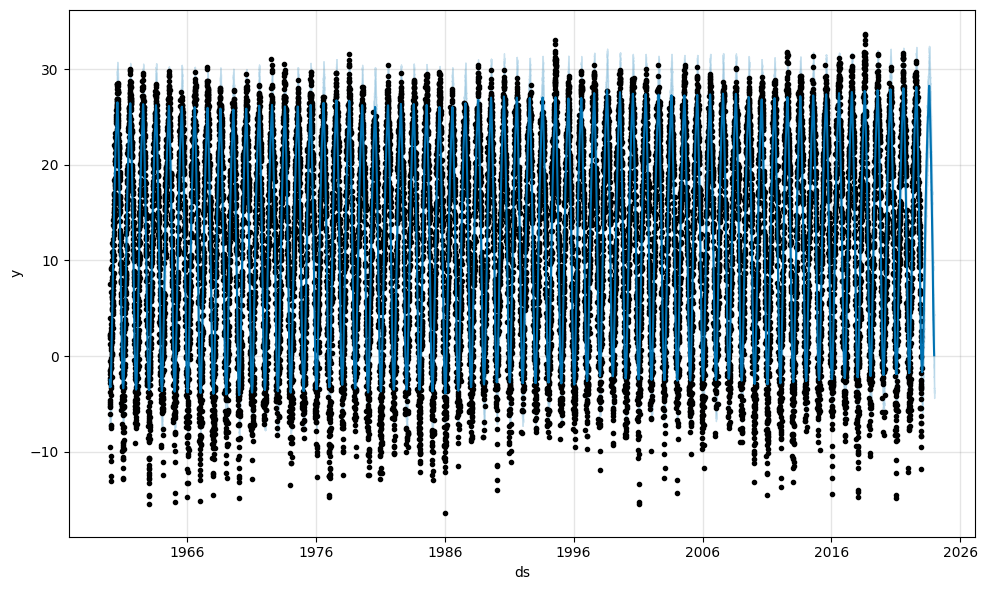

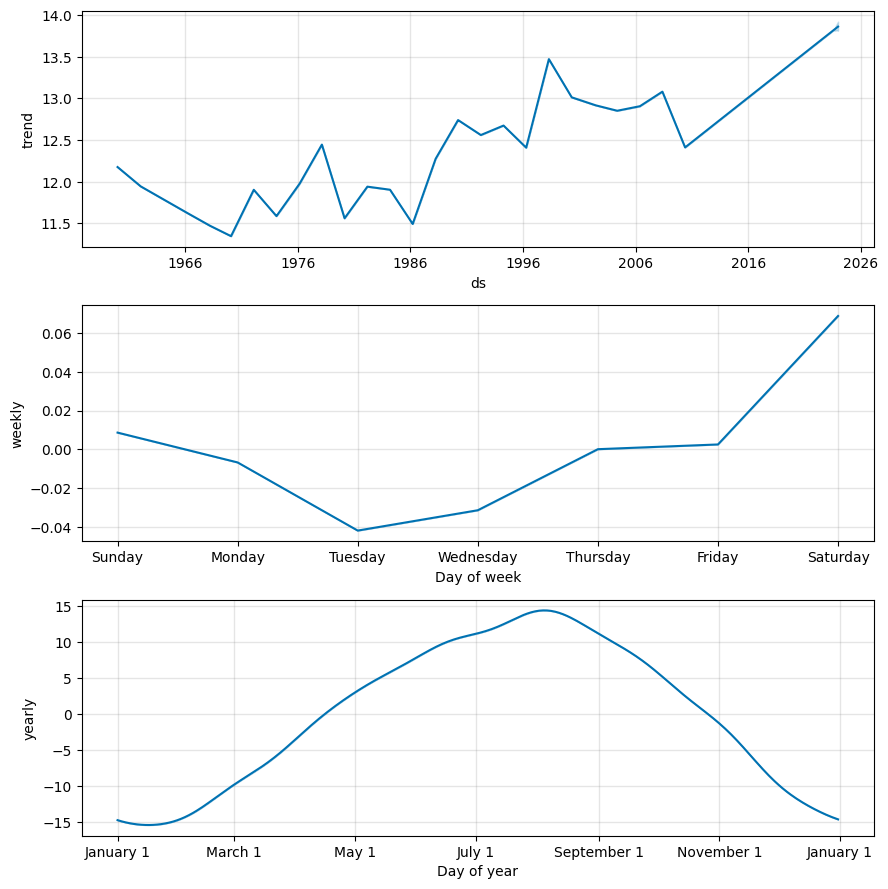

In [ ]:
split_year = 2021  # 예시로 2021년을 기준으로 분할
train = df[df['ds'].dt.year < split_year]
validate = df[df['ds'].dt.year == split_year]

# 목적 함수 정의
def objective(params):
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=True  # 연간 계절성 활성화
    )
    m.fit(train)
    future = m.make_future_dataframe(periods=len(validate))
    forecast = m.predict(future)
    mae = mean_absolute_error(validate['y'], forecast['yhat'][-len(validate):])
    return {'loss': mae, 'status': STATUS_OK}

# 하이퍼파라미터 공간 정의
space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', np.log(0.001), np.log(0.5)),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', np.log(0.01), np.log(10)),
}

# 최적화 실행
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=35)

# 최적의 하이퍼파라미터 출력
print(best)

# 최적화된 하이퍼파라미터로 모델 피팅
m = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=best['changepoint_prior_scale'],
    seasonality_prior_scale=best['seasonality_prior_scale']
)
m.fit(df)

# 전체 데이터에 대한 예측 수행
future = m.make_future_dataframe(periods=358)  # or any other number of periods you want
forecast = m.predict(future)

# 예측 결과 시각화
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,12.176720,-6.515752,1.418868,12.176720,12.176720,-14.660883,-14.660883,-14.660883,0.002525,0.002525,0.002525,-14.663407,-14.663407,-14.663407,0.0,0.0,0.0,-2.484163
1,1960-01-02,12.176409,-6.414052,1.537829,12.176409,12.176409,-14.682400,-14.682400,-14.682400,0.068749,0.068749,0.068749,-14.751149,-14.751149,-14.751149,0.0,0.0,0.0,-2.505991
2,1960-01-03,12.176098,-6.522145,1.285294,12.176098,12.176098,-14.824969,-14.824969,-14.824969,0.008635,0.008635,0.008635,-14.833604,-14.833604,-14.833604,0.0,0.0,0.0,-2.648871
3,1960-01-04,12.175787,-6.710847,1.401985,12.175787,12.175787,-14.917397,-14.917397,-14.917397,-0.006744,-0.006744,-0.006744,-14.910653,-14.910653,-14.910653,0.0,0.0,0.0,-2.741610
4,1960-01-05,12.175476,-6.912859,1.274600,12.175476,12.175476,-15.024061,-15.024061,-15.024061,-0.041867,-0.041867,-0.041867,-14.982194,-14.982194,-14.982194,0.0,0.0,0.0,-2.848585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23364,2023-12-20,13.860235,-3.285108,4.717418,13.814381,13.918155,-13.288847,-13.288847,-13.288847,-0.031386,-0.031386,-0.031386,-13.257461,-13.257461,-13.257461,0.0,0.0,0.0,0.571388
23365,2023-12-21,13.860527,-3.855975,4.716591,13.814743,13.919245,-13.396101,-13.396101,-13.396101,0.000088,0.000088,0.000088,-13.396189,-13.396189,-13.396189,0.0,0.0,0.0,0.464426
23366,2023-12-22,13.860819,-3.500130,4.264330,13.815105,13.920334,-13.528816,-13.528816,-13.528816,0.002525,0.002525,0.002525,-13.531341,-13.531341,-13.531341,0.0,0.0,0.0,0.332003
23367,2023-12-23,13.861111,-3.579540,4.411330,13.815468,13.921418,-13.594129,-13.594129,-13.594129,0.068749,0.068749,0.068749,-13.662878,-13.662878,-13.662878,0.0,0.0,0.0,0.266982


In [ ]:
# predict = list(forecast[forecast['ds'].apply(lambda x:x.year)==2023]['yhat'])
# submission['평균기온'] = np.round(predict,1)

# from google.colab import files
# submission.to_csv('(12.31)prophet_tuning.csv', index = False)
# files.download('(12.31)prophet_tuning.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df

,ds,y
0,1960-01-01,-1.6
1,1960-01-02,-1.9
2,1960-01-03,4.0
3,1960-01-04,7.5
4,1960-01-05,-4.6
...,...,...
23006,2022-12-27,-2.6
23007,2022-12-28,-3.3
23008,2022-12-29,-2.9
23009,2022-12-30,-1.8
